In [1]:
#RNN계층 구현

class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        #가중치 2개, 편향 1개
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        #각 매개변수에 대응하는 형태로 기울기를 초기화한 후 grads에 저장
        self.cache = None
        #역전파 계산 시 사용하는 중간 데이터를 담은 cache를 None으로 초기화

    def forward(self, x, h_prev):
        #아래로부터의 입력 x와 왼쪽으로부터의 입력 h_prev
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        #matmul: 행렬의 곱
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    #RNN계층의 역전파 메서드 구현
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next*(1-h_next**2)
        db = np.sum(dt, axis=0)
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dWx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

In [3]:
#TimeRNN계층 구현
#RNN클래스를 이용해 T개 단계의 처리를 한꺼번에 수행하는 계층을 
#TimeRNN이란 이름의 클래스로 완성한다.

class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        #초기화 메서드는 가중치, 편향, stateful이라는 boolean값을 인수로 받음
        #stateful=True : Time RNN계층이 은닉 상태를 유지한다.->아무리 긴 시계열 데이터라도 Time RNN계층의 순전파를 끊지 않고 전파한다.
        #stateful=False: Time RNN 계층은 은닉 상태를 '영행렬'로 초기화한다.상태가 없다.
        self.params = [Wx, Wh, b]
        self.grads = [np.zeors_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        #layers : 다수의 RNN계층을 리스트로 저장하는 용도

        self.h, self.dh = None, None
        #h: forward() 메서드를 불렀을 때 마지막 RNN 계층의 은닉 상태를 저장
        #dh: backward()를 불렀을 때 하나 앞 블록의 은닉 상태의 기울기를 저장한다.
        self.stateful = stateful

    def set_state(self, h):
        #Time RNN계층의 은닉 상태를 설정하는 메서드
        self.h = h

    def reset_state(self):
        #은닉 상태를 초기화하는 메서드
        self.h = None

    #순전파 구현
    def forward(self, xs):
      #아래로부터 입력 xs(T개 분량의 시계열 데이터를 하나로 모은 것)를 받는다.
        Wx, Wh, b = self.params
        N, T, D = xs.shape #N: 미니배치 크기 D: 입력 벡터의 차원 수
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        #출력값을 담을 그릇 hs를 준비한다.

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
            #h: RNN 계층의 은닉 상태. 
            #self.h=None: 처음 호출 시에는 원소가 모두 0인 영행렬로 초기화됨.
            #stateful=False: 항상 영행렬로 초기화

        for t in range(T):
            layer = RNN(*self.params)
            # *: 리스트의 원소들을 추출하여 메서드의 인수로 전달
            #self.params에 들어 있는 Wx, Wh, b를 추출하여 RNN 클래스의 __init__()메서드에 전달
            #RNN계층을 생성하여 인스턴스 변수 layers에 추가한다.
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    #역전파 구현
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh) #합산된 기울기
            #RNN계층의 순전파에서는 출력이 2개로 분기되는데 역전파에서는 각 기울기가 합산되어 전해진다.
            dxs[:, t, :] = dx

        for i, grad in enumerate(layer.grads):
            grads[i] +=grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            self.dh = dh

        return dxs

In [5]:
#4개의 Time계층을 쌓은 신경망 SimpleRnnlm클래스

import sys
sys.path.append('..')
import numpy as np
from common.time_layers import * 

#SimpleRnnlm클래스는 4개의 Time계층을 쌓은 신경망이다.
class SimpleRnnlm:
    def __init__(self, vocab_sizse, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        #가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)), astype('f')
        affine_b = np.zeros(V).astype('f')
        #RNN 계층과 Affine계층에서 'Xabier초깃값'을 이용


        #계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            #Truncated BPTT로 학습한다고 가정하여 Time RNN계층의 stateful=True로 설정 
            #-> TimeRNN계층은 이전 시간의 은닉 상태를 계승할 수 있다.
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        #모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [],[]
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
                                          
        def forward(self, xs, ts):
            for layer in self.layers:
                xs = layer.forward(xs)
                loss = self.loss_layer.forward(xs, ts)
            return loss

        def backward(self, dout=1):
            dout = self.loss_layer.backward(dout)
            for layer in reversed(self.layers):
                dout = layer.backward(dout)
            return dout

        def reset_state(self):
            self.rnn_layer.reset_state()                                 
                                      

In [7]:
#RNNLM 학습 코드
#1000개 단어만 이용
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm


# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 402.25
| 에폭 2 | 퍼플렉서티 275.78
| 에폭 3 | 퍼플렉서티 230.07
| 에폭 4 | 퍼플렉서티 217.46
| 에폭 5 | 퍼플렉서티 207.50
| 에폭 6 | 퍼플렉서티 202.55
| 에폭 7 | 퍼플렉서티 198.79
| 에폭 8 | 퍼플렉서티 196.90
| 에폭 9 | 퍼플렉서티 191.79
| 에폭 10 | 퍼플렉서티 192.75
| 에폭 11 | 퍼플렉서티 188.92
| 에폭 12 | 퍼플렉서티 191.42
| 에폭 13 | 퍼플렉서티 188.97
| 에폭 14 | 퍼플렉서티 189.58
| 에폭 15 | 퍼플렉서티 188.19
| 에폭 16 | 퍼플렉서티 184.40
| 에폭 17 | 퍼플렉서티 182.43
| 에폭 18 | 퍼플렉서티 179.52
| 에폭 19 | 퍼플렉서티 180.03
| 에폭 20 | 퍼플렉서티 180.67
| 에폭 21 | 퍼플렉서티 180.73
| 에폭 22 | 퍼플렉서티 177.46
| 에폭 23 | 퍼플렉서티 173.45
| 에폭 24 | 퍼플렉서티 174.21
| 에폭 25 | 퍼플렉서티 171.86
| 에폭 26 | 퍼플렉서티 172.05
| 에폭 27 | 퍼플렉서티 166.38
| 에폭 28 | 퍼플렉서티 164.66
| 에폭 29 | 퍼플렉서티 163.73
| 에폭 30 | 퍼플렉서티 155.58
| 에폭 31 | 퍼플렉서티 157.10
| 에폭 32 | 퍼플렉서티 153.14
| 에폭 33 | 퍼플렉서티 150.02
| 에폭 34 | 퍼플렉서티 145.67
| 에폭 35 | 퍼플렉서티 142.95
| 에폭 36 | 퍼플렉서티 137.02
| 에폭 37 | 퍼플렉서티 134.96
| 에폭 38 | 퍼플렉서티 130.95
| 에폭 39 | 퍼플렉서티 125.30
| 에폭 40 | 퍼플렉서티 121.80
| 에폭 41 | 퍼플렉서티 121.56
| 에폭 42 | 퍼플렉서티 114.14
| 에폭 43 | 퍼플렉서티 109

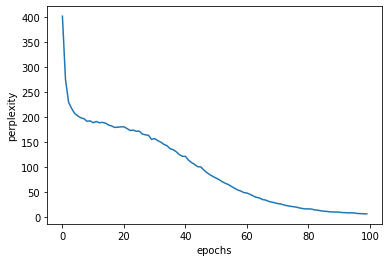

In [8]:
# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

#학습을 진행하수록 퍼플렉서티가 순조롭게 낮아짐을 알 수 있다.

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 417.75
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 398.18
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 292.22
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 229.96
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 214.29
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 211.60
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 202.09
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 201.26
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 195.48
| 에폭 10 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 190.32
| 에폭 11 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 193.20
| 에폭 12 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 188.91
| 에폭 13 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 193.27
| 에폭 14 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 187.25
| 에폭 15 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 186.41
| 에폭 16 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 190.22
| 에폭 17 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 188.12
| 에폭 18 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 184.09
| 에폭 19 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 180.91
| 에폭 20 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 182.44
| 에폭 21 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 178.83
| 에폭 22 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 177.

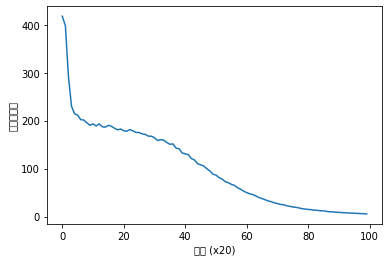

In [18]:
#RNNLM 학습을 수행해주는 RnnlmTrainer클래스
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from dataset import ptb
from simple_rnnlm import SimpleRnnlm

# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm


# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # 테스트 데이터셋을 작게 설정
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 입력
ts = corpus[1:]  # 출력（정답 레이블）

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()